In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


2025-05-25 17:52:32.671594: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 17:52:32.685468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748188352.696883  189726 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748188352.700219  189726 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748188352.712644  189726 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import os
Git_Folder = os.path.dirname(os.path.dirname(os.getcwd()))
Christian_folder = os.path.join(os.path.dirname(Git_Folder))

# LSTM encoder-decoder for seq-to-seq prediction

## Datageneration:

In [4]:
def random_sine(samples,
                seq_length,
                # min_index, max_index, #Indices in the data array that delimit which timesteps to draw from (used for data that isn't randomly generated)
                freq = np.array([0.1, 1]),
                ampl = np.array([0.1, 1]),
                offset = np.array([-1, 1]),
                num_sine_waves = 2,
                seed = 43):
    np.random.seed(seed)
    rows = np.linspace(0, 10, seq_length)

    amplitude = np.random.uniform(ampl[0], ampl[1], (samples, num_sine_waves, 1))
    frequency = np.random.uniform(freq[0], freq[1], (samples, num_sine_waves, 1))
    offset =    np.random.uniform(offset[0], offset[1], (samples, num_sine_waves, 1))
    phase =     np.random.uniform(0, 2*np.pi, (samples, num_sine_waves, 1))
    sinewaves = amplitude * np.sin(2 * np.pi * frequency * rows + phase) + offset

    signals = np.sum(sinewaves, axis = 1) #Sums the number of sine waves  

    return signals

## preparing data

In [5]:
import os

In [6]:
# RF_modulation_folder = '//unicph.domain\\groupdir\\SCI-NBI-quantop-data\\data\\gwd\\Experimental Data\\atoms\\2025\\2025-04-25 Tulio Jun - simple RF modulation for ML\\RF modulation'
# filenames = os.listdir(RF_modulation_folder)
# run_2_50_square = [file for file in filenames if file.startswith('run2_RF_modulation_square')]
# run_2_50_square.sort()
# run_2_50_square

In [7]:
from scipy.io import loadmat

In [8]:
# os.listdir()

In [9]:
sample_01 = loadmat("/home/qopt/Christian/run2_RF_modulation_square_2Hz_sample_01.mat")#os.path.join("C:\\Users\\maimo\\OneDrive\\Bureau\\Christian\\Data", run_2_50_square[0]))


In [10]:
from scipy.signal import envelope

In [11]:
x_env, x_res = envelope(sample_01["RF_YmV"][0])

In [12]:
def reshape_signal(signal, n_signals):
# n_signals = 2000
# signal = x_res + x_env #sample_01['lock_in_aux_out_YmV'][0] #np.arange(0, len_init_signal)

    len_init_signal = len(signal)
    remainder = len_init_signal%n_signals


    if remainder == 0:
        signal = signal.reshape(n_signals, -1)
    else:
        signal = signal[:-remainder].reshape(n_signals, -1)
    return signal
# print(signal.shape)

In [13]:
batch_size = 200  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 150  # Latent dimensionality of the encoding space.
num_samples = int(len(sample_01['lock_in_aux_out_YmV'][0])/5000)  # Number of samples to train on.
num_features = 1


# data = random_sine(samples = num_samples, seq_length=seq_length)

# data = np.expand_dims(data, axis=2)

X = np.expand_dims(reshape_signal(sample_01['lock_in_aux_out_YmV'][0], num_samples), axis = 2)
Y = np.expand_dims(reshape_signal(x_res+x_env, num_samples), axis = 2)

X_train = X[:int(0.8*num_samples), :, :]
Y_train = Y[:int(0.8*num_samples), :, :]

X_test = X[:int(0.8*num_samples), :, :]
Y_test = Y[:int(0.8*num_samples), :, :]

num_encoder_tokens = X.shape[1]
num_decoder_tokens = Y.shape[1]

In [14]:
X.shape

(12000, 5000, 1)

In [15]:
asd = random_sine(samples = num_samples, seq_length=100).shape
# X_test.shape
np.random.randint(0, num_samples, 10)

array([ 7676, 10395,   762,  5014,  3677, 10673,  4404,   707,  9436,
        3165])

In [16]:
# asd = np.arange(0,100).reshape(10, -1)
# np.expand_dims(asd, axis = 2)

## Setting up the model

In [17]:
# Define an input sequence and process it.
encoder_inputs = tf.keras.Input(shape=(num_encoder_tokens, 1))
encoder = tf.keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = tf.keras.Input(shape=(num_decoder_tokens, 1))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(1, activation="linear")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


I0000 00:00:1748188360.367124  189726 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13709 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6


In [18]:
print("Num GPUs Available (TF): ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available (TF):  1


## Training the model

In [19]:
# model.compile(
#     optimizer="adam", loss="mse"
# )
# history = model.fit(
#     [X_train, np.zeros_like(Y_train)],
#     Y_train,
#     batch_size=batch_size,
#     epochs=epochs,
#     validation_split=0.2,
# )
# # Save model
# model.save("s2s_model.keras")

## Testing the model on unseen data

In [20]:
np.where(Y_test > 10)
np.where(Y_test[16] > 10)
Y_test[16]
np.arange(14, 18)
# np.arange(100)[14:18]

array([14, 15, 16, 17])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


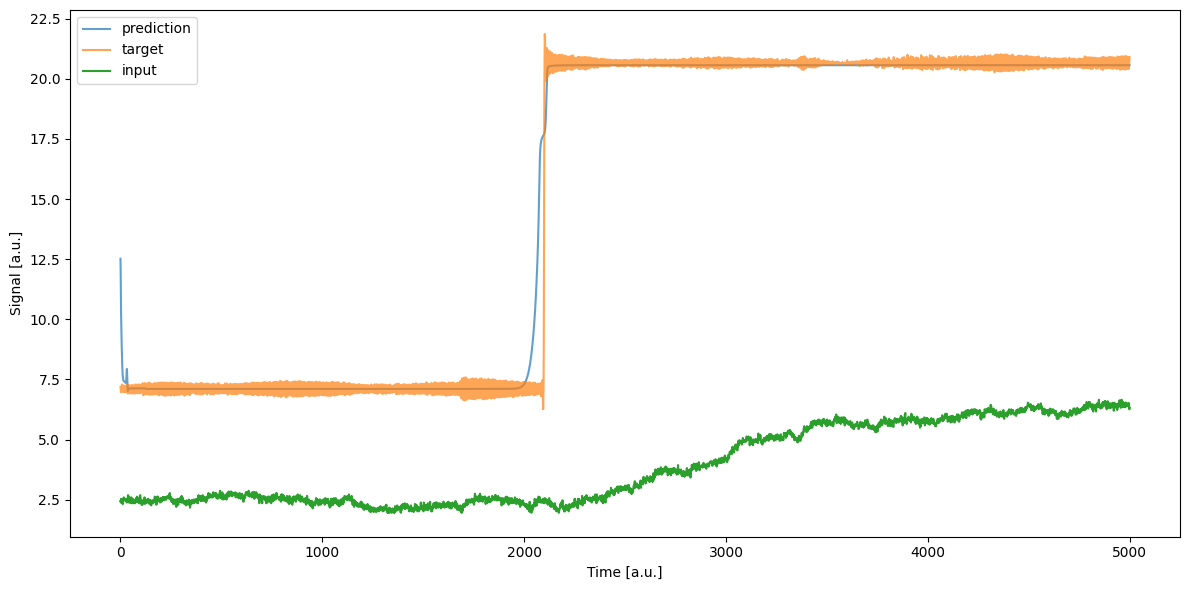

In [31]:
# model = tf.keras.models.load_model("s2s_model.keras")
model = tf.keras.models.load_model(os.path.join(Christian_folder, "s2s_model.keras"))


# model.predict([X_test, np.zeros_like(Y_test)]).shape
test_min = 16
test_max = 17
test_index = np.arange(test_min, test_max)

predictions = model.predict([X_test[test_min:test_max], np.zeros_like(Y_test[test_min:test_max])])
# print(predictions[0][:, 0])

# t = np.linspace(0, 10, seq_le'ngth)*2*np.pi
# t_x = t[:int(seq_length*0.8)]
# t_y = t[int(seq_length*0.8):]'

plt.figure(figsize=(12, 6))

for i in range(test_max-test_min):
    # plt.show()
    plt.plot(predictions[i][:, 0], label = 'prediction', alpha = 0.7)
    plt.plot(Y_test[test_index[i]][:, 0], label = 'target', alpha = 0.7)
    plt.plot(X_test[test_index[i]][:, 0], label = 'input')
    plt.xlabel("Time [a.u.]")
    plt.ylabel("Signal [a.u.]")
    # print(list(tests)[i][1][:, 0])
    # if i == 0
    # plt.show()
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(Git_Folder, "Figures", "Square_wave.svg"))

    plt.show()
